In [ ]:
# !pip install caas_jupyter_tools

In [ ]:
# Vamos filtrar por Viana + ANO_ELEICAO == 2024 + DESCRICAO_CARGO == 'PREFEITO' e identificar colunas de partido e votos
import pandas as pd, os
# from caas_jupyter_tools import display_dataframe_to_user

f = '/content/dadosS1.csv'
df = pd.read_csv(f, encoding='utf-8', sep=None, engine='python')

mask_viana = df.apply(lambda row: row.astype(str).str.contains('Viana', case=False, na=False).any(), axis=1)
df_viana = df[mask_viana].copy()
df_viana_2024_pref = df[(df['ANO_ELEICAO']==2024) & (df['DESCRICAO_CARGO'].astype(str).str.upper().str.contains('PREFEITO')) & mask_viana]

print(f"Linhas Viana 2024 PREFEITO: {len(df_viana_2024_pref)}")
# display_dataframe_to_user("Amostra Viana 2024 Prefeito", df_viana_2024_pref.head(200))
display(df_viana_2024_pref.head(200))

# Identify likely party and vote-related columns
party_like = [c for c in df.columns if 'PARTIDO' in c.upper() or 'SIGLA' in c.upper() or 'SIG' in c.upper()]
votes_like = [c for c in df.columns if 'VOTOS' in c.upper() or 'VOTACAO' in c.upper() or 'QT' in c.upper() or 'TOTAL' in c.upper()]
print("Party-like columns:", party_like)
print("Votes-like columns (some):", votes_like[:20])

# Show unique values for party-like columns to pick correct one
for c in party_like[:10]:
    print(f"Unique values in {c}:", df[c].astype(str).unique()[:30])

# If we have columns like 'SIGLA_PARTIDO' and 'QT_VOTOS', use them to compute NEP
# Heuristics: common column names are 'SIGLA_PARTIDO' and 'QT_VOTOS'
possible_party_col = None
possible_votes_col = None
for c in df.columns:
    if c.upper() in ['SIGLA_PARTIDO', 'SIGLA', 'PARTIDO']:
        possible_party_col = c
for c in df.columns:
    if c.upper() in ['QT_VOTOS', 'VOTOS', 'QT_VOTOS_NOMINAIS', 'QT_VOTOS_LEGENDA', 'QTVOTOS']:
        possible_votes_col = c

# If heuristics fail, fall back to any party-like and votes-like found
if not possible_party_col and party_like:
    possible_party_col = party_like[0]
if not possible_votes_col and votes_like:
    possible_votes_col = votes_like[0]

print("Escolhendo colunas para party/votes:", possible_party_col, possible_votes_col)

if possible_party_col and possible_votes_col and not df_viana_2024_pref.empty:
    candidates = df_viana_2024_pref[[possible_party_col, possible_votes_col]].copy()
    candidates.columns = ['party', 'votes']
    candidates['votes'] = pd.to_numeric(candidates['votes'], errors='coerce')
    # Try to find votos validos column
    valid_cols = [c for c in df.columns if 'VOTOS_VALID' in c.upper() or 'VALIDOS' in c.upper() or 'VOTOSVALID' in c.upper()]
    valid_col = valid_cols[0] if valid_cols else None
    if valid_col:
        valid_votes = pd.to_numeric(df_viana_2024_pref[valid_col].iloc[0], errors='coerce')
    else:
        valid_votes = candidates['votes'].sum()
    agg = candidates.groupby('party', dropna=False)['votes'].sum().reset_index()
    agg['fraction'] = agg['votes'] / valid_votes
    agg['fraction_sq'] = agg['fraction']**2
    agg = agg.sort_values('votes', ascending=False).reset_index(drop=True)
    sum_sq = agg['fraction_sq'].sum()
    nep = 1.0/sum_sq if sum_sq>0 else None

    display(agg)
    print(f"Votos válidos (usados para fração): {valid_votes}")
    print(f"Soma das frações ao quadrado: {sum_sq}")
    print(f"NEP: {nep}")
else:
    print("Não foi possível calcular automaticamente com heurísticas. Posso mostrar as colunas e linhas para você escolher manualmente.")

Linhas Viana 2024 PREFEITO: 3


,ANO_ELEICAO,SIGLA_UF,CODIGO_MUNICIPIO,NOME_MUNICIPIO,DESCRICAO_CARGO,SIGLA_PARTIDO,VOTOS_PARTIDO,VOTOS_VALIDOS,PCT,CALC
9650,2024,ES,57010,VIANA,Prefeito,DC,928,40638,2.28,0.0005
9651,2024,ES,57010,VIANA,Prefeito,PODE,37587,40638,92.49,0.8555
9652,2024,ES,57010,VIANA,Prefeito,PV,2123,40638,5.22,0.0027


Party-like columns: ['SIGLA_UF', 'SIGLA_PARTIDO', 'VOTOS_PARTIDO']
Votes-like columns (some): ['VOTOS_PARTIDO', 'VOTOS_VALIDOS']
Unique values in SIGLA_UF: ['ES']
Unique values in SIGLA_PARTIDO: ['PFL' 'PPS' 'PSC' 'PDT' 'PL' 'PMDB' 'PMN' 'PPB' 'PSB' 'PSDB' 'PT' 'PTB'
 'PHS' 'PSD' 'PSL' 'PST' 'PTN' 'PV' 'PRP' 'PSDC' 'PC do B' 'PT do B' 'PGT'
 'PRN' 'PAN' 'PRTB' 'PCO' 'PSTU' 'PP' 'PTC']
Unique values in VOTOS_PARTIDO: ['10313' '2558' '3930' '306' '3254' '3436' '536' '180' '720' '2584' '849'
 '2316' '1018' '954' '1282' '4799' '3602' '1251' '1188' '127' '18' '169'
 '2053' '1339' '221' '2576' '1973' '3330' '813' '782']
Escolhendo colunas para party/votes: SIGLA_PARTIDO VOTOS_PARTIDO


,party,votes,fraction,fraction_sq
0,PODE,37587,0.924922,0.855482
1,PV,2123,0.052242,0.002729
2,DC,928,0.022836,0.000521


Votos válidos (usados para fração): 40638
Soma das frações ao quadrado: 0.8587322779452079
NEP: 1.1645072925322202


0.924922 + 0.052242 + 0.022836


,Ano,2000,Unnamed: 2,2004,Unnamed: 4,2008,Unnamed: 6,2012,Unnamed: 8,2016,Unnamed: 10,2020,Unnamed: 12,2024,Unnamed: 14
0,Row Labels,PREFEITO,VEREADOR,PREFEITO,VEREADOR,PREFEITO,VEREADOR,PREFEITO,VEREADOR,PREFEITO,VEREADOR,PREFEITO,VEREADOR,PREFEITO,VEREADOR
1,VIANA,2.2,7.8,2.7,12.0,2.4,9.9,1.9,7.9,1.7,13.2,2.1,10.4,1.2,5.4



--- Passo 2: Gráfico Gerado ---
O gráfico foi salvo com o nome 'nep_viana_2000_2024.png'


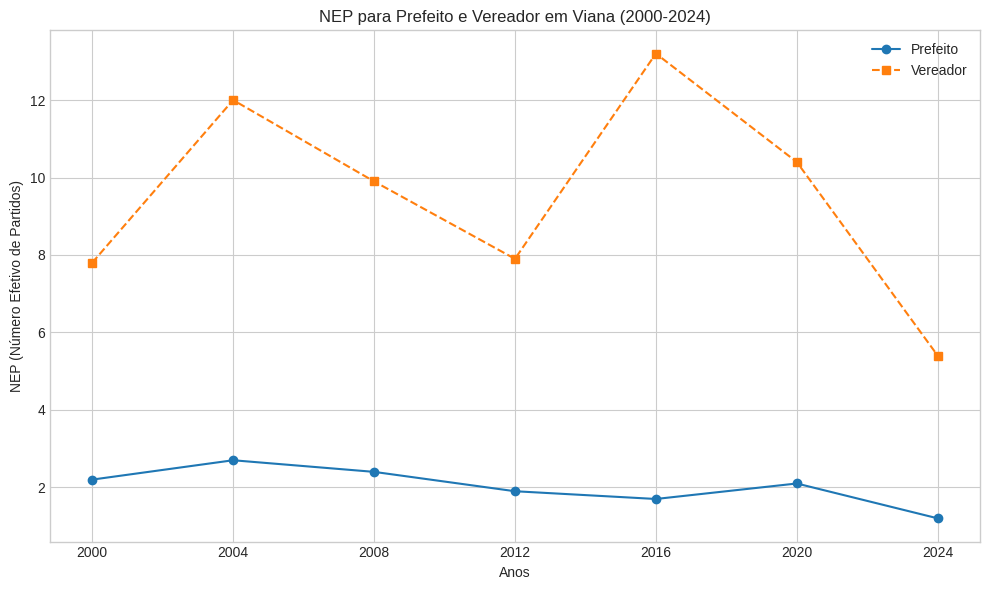

In [ ]:
# Passo 2: Geração do Gráfico
import matplotlib.pyplot as plt
import pandas as pd # Import pandas as it might not be imported in this cell

df2 = pd.read_csv('/content/dadosS2.csv')
display(df2.head())

# Filtra os dados de NEP para Viana no segundo dataframe
# Corrected column name from 'Unnamed: 0' to 'Ano'
df_viana = df2[df2['Ano'] == 'VIANA'].iloc[0]

# Prepara as listas de dados para o gráfico
anos = [2000, 2004, 2008, 2012, 2016, 2020, 2024]
# Corrected column names based on df2.head() output
nep_prefeito = [
    df_viana['2000'], df_viana['2004'], df_viana['2008'],
    df_viana['2012'], df_viana['2016'], df_viana['2020'],
    df_viana['2024']
]
# Corrected column names based on df2.head() output
nep_vereador = [
    df_viana['Unnamed: 2'], df_viana['Unnamed: 4'], df_viana['Unnamed: 6'],
    df_viana['Unnamed: 8'], df_viana['Unnamed: 10'], df_viana['Unnamed: 12'],
    df_viana['Unnamed: 14']
]

# Convert NEP values to numeric, coercing errors
nep_prefeito = pd.to_numeric(nep_prefeito, errors='coerce')
nep_vereador = pd.to_numeric(nep_vereador, errors='coerce')


# Cria o gráfico
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(anos, nep_prefeito, marker='o', linestyle='-', label='Prefeito')
ax.plot(anos, nep_vereador, marker='s', linestyle='--', label='Vereador')

# Adiciona os elementos gráficos (títulos, legendas, etc.)
ax.set_xlabel("Anos")
ax.set_ylabel("NEP (Número Efetivo de Partidos)")
ax.set_title("NEP para Prefeito e Vereador em Viana (2000-2024)")
ax.legend()
ax.grid(True)
plt.xticks(anos)
plt.tight_layout()

# Salva o gráfico como um arquivo de imagem
plt.savefig("nep_viana_2000_2024.png")

print("\n--- Passo 2: Gráfico Gerado ---")
print("O gráfico foi salvo com o nome 'nep_viana_2000_2024.png'")